In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from DataGenerator import *
from AnalyticalSolution import *
from Switcher import *
from Calculator import *
from GradientDescent import *
from ConjugateGradient import *

%matplotlib inline
sns.set()

In [98]:
# 超参数
TRAIN_NUM = 15 # 训练集规模
VALIDATION_NUM = 100 # 验证集规模
TEST_NUM = 1000 # 测试集规模
ORDER = 6 # 阶数
X_LEFT = 0 # 左界限
X_RIGHT = 1 # 右界限
NOISE_SCALE = 0.25 # 噪音标准差
LEARNING_RATE = 0.1 # 梯度下降学习率
DELTA = 1e-6 # 优化残差界限
W_SOLUTION = pd.DataFrame() # 不同方法的w解

def base_func(x):
    """原始函数
    """
    return np.sin(2 * np.pi * x)

# 训练集
train_data = get_data(
    x_range=(X_LEFT, X_RIGHT),
    sample_num=TRAIN_NUM,
    base_func=base_func,
    noise_scale=NOISE_SCALE,
)
X_TRAIN = train_data["X"]
Y_TRAIN = train_data["Y"]

# 验证集
X_VALIDATION = np.linspace(X_LEFT, X_RIGHT, VALIDATION_NUM)
Y_VALIDATION = base_func(X_VALIDATION)

# 测试集
X_TEST = np.linspace(X_LEFT, X_RIGHT, TEST_NUM)
Y_TEST = base_func(X_TEST)

train_data

,X,Y
0,0.000000,-0.105207
1,0.071429,0.705463
2,0.142857,1.096564
3,0.214286,0.765393
4,0.285714,0.714735
5,0.357143,0.960211
6,0.428571,0.049535
7,0.500000,-0.083812
8,0.571429,-0.724317
9,0.642857,-0.660602


# 可视化拟合结果

In [99]:
def show_fit_solution(x_train, y_train, x, y_pred, y_true):
    """可视化：训练集点、原始函数、拟合函数
    """
    d = pd.DataFrame(
        np.concatenate(
            (
                np.transpose([X_TEST, y_true, ["True"] * TEST_NUM]),
                np.transpose([X_TEST, y_pred, ["Pred"] * TEST_NUM]),
            )
        ),
        columns=["X", "Y", "type"],
    )
    d[["X", "Y"]] = d[["X", "Y"]].astype("float")
    sns.lineplot(x="X", y="Y", data=d, hue="type")
    plt.scatter(x=x_train, y=y_train, color="green")

# 解析解

In [100]:
def get_y_pred_by_analytical(x_train, y_train, x, with_penalty=False, lambda_penalty=None):
    assert not with_penalty or lambda_penalty is not None  # 有惩罚项时，lambda不为空
    x_vec, t_vec = x_train, y_train
    w_vec = (
        get_params_with_penalty(
            x_matrix=get_x_matrix(x_vec, order=ORDER),
            t_vec=t_vec,
            lambda_penalty=lambda_penalty,
        )
        if with_penalty
        else get_params(x_matrix=get_x_matrix(x_vec, order=ORDER), t_vec=t_vec)
    )
    return np.dot(get_x_matrix(x, order=ORDER), w_vec), w_vec

# 不带惩罚项解析解

In [101]:
y_pred, w_vec = get_y_pred_by_analytical(x_train=X_TRAIN, y_train=Y_TRAIN, x=X_TEST, with_penalty=False)
W_SOLUTION["Analytical_Without_Penalty"] = w_vec

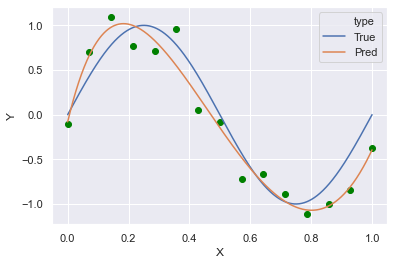

In [102]:
show_fit_solution(x_train=X_TRAIN, y_train=Y_TRAIN, x=X_TEST, y_pred=y_pred, y_true=Y_TEST)

# 带惩罚项解析解

In [103]:
def show_lambda_error(error_ln_lambda):
    data = pd.DataFrame(error_ln_lambda, columns=["$ln{\lambda}$", "$E_{rms}$", "type"])
    sns.lineplot(x="$ln{\lambda}$", y="$E_{rms}$", data=data, hue="type")
    idxmin = error_ln_lambda[data[data["type"]=="VALIDATION"]["$E_{rms}$"].idxmin()]
    plt.title(label=("Min: $e^{" + str(int(idxmin[0])) + "}, " + "{:.3f}".format(idxmin[1]) + "$"))
    return np.power(np.e, idxmin[0]), idxmin[1]

In [104]:
error_ln_lambda = []
for i in range(-50, 0):
    y_pred, w_vec = get_y_pred_by_analytical(
        x_train=X_TRAIN,
        y_train=Y_TRAIN,
        x=X_TRAIN, # 训练集
        with_penalty=True,
        lambda_penalty=np.exp(i),
    )
    error_ln_lambda.append([i, calc_e_rms(y_pred=y_pred, y_true=Y_TRAIN), "TRAIN"]) # 训练集上的根均方误差
    y_pred, w_vec = get_y_pred_by_analytical(
        x_train=X_TRAIN,
        y_train=Y_TRAIN,
        x=X_VALIDATION, # 验证集
        with_penalty=True,
        lambda_penalty=np.exp(i),
    )
    error_ln_lambda.append([i, calc_e_rms(y_pred=y_pred, y_true=Y_VALIDATION), "VALIDATION"]) # 测试集上的根均方误差

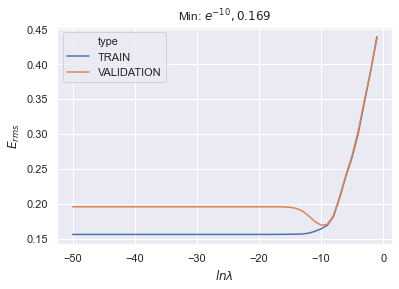

In [105]:
best_lambda, least_loss = show_lambda_error(error_ln_lambda)

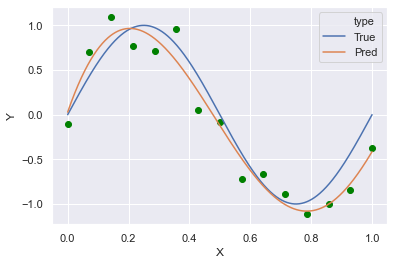

In [106]:
y_pred, w_vec = get_y_pred_by_analytical(x_train=X_TRAIN, y_train=Y_TRAIN, x=X_TEST, with_penalty=True, lambda_penalty=best_lambda)
W_SOLUTION["Analytical_With_Penalty"] = w_vec
show_fit_solution(x_train=X_TRAIN, y_train=Y_TRAIN, x=X_TEST, y_pred=y_pred, y_true=Y_TEST)

# 梯度下降法

In [107]:
def get_y_pred_by_gradient_descent(x_train, y_train, x, lambda_penalty):
    x_vec, t_vec = x_train, y_train
    k, w_vec = gradient_descent_fit(
        x_matrix=get_x_matrix(x_vec, order=ORDER),
        t_vec=t_vec,
        lambda_penalty=lambda_penalty,
        w_vec_0=np.zeros(ORDER + 1),
        learning_rate=LEARNING_RATE,
        delta=DELTA,
    )
    return k, np.dot(get_x_matrix(x, order=ORDER), w_vec), w_vec

In [108]:
k, y_pred, w_vec = get_y_pred_by_gradient_descent(
    x_train=X_TRAIN,
    y_train=Y_TRAIN,
    x=X_TEST,
    lambda_penalty=best_lambda,
)
W_SOLUTION["Gradient_Descent"] = w_vec
k

44928

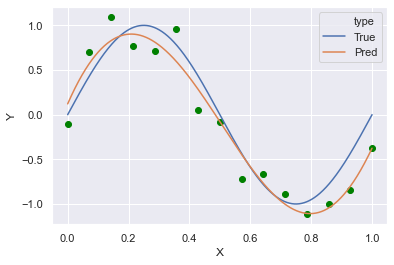

In [109]:
show_fit_solution(x_train=X_TRAIN, y_train=Y_TRAIN, x=X_TEST, y_pred=y_pred, y_true=Y_TEST)

# 共轭梯度法

In [110]:
def get_y_pred_by_conjugate_gradient(x_train, y_train, x, lambda_penalty):
    x_vec, t_vec = x_train, y_train
    A, x_0, b = switch_deri_func_for_conjugate_gradient(
        x_matrix=get_x_matrix(x_vec, order=ORDER),
        t_vec=t_vec,
        lambda_penalty=lambda_penalty,
        w_vec=np.zeros(ORDER + 1),
    )
    k, w_vec = conjugate_gradient_fit(A=A, x_0=x_0, b=b, delta=DELTA)
    return k, np.dot(get_x_matrix(x, order=ORDER), w_vec), w_vec

In [111]:
k, y_pred, w_vec = get_y_pred_by_conjugate_gradient(
    x_train=X_TRAIN,
    y_train=Y_TRAIN,
    x=X_TEST,
    lambda_penalty=best_lambda,
)
W_SOLUTION["Conjugate_Gradient"] = w_vec
k

5

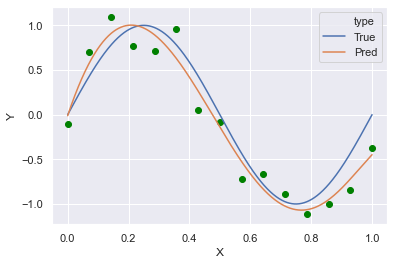

In [112]:
show_fit_solution(x_train=X_TRAIN, y_train=Y_TRAIN, x=X_TEST, y_pred=y_pred, y_true=Y_TEST)

In [113]:
W_SOLUTION

,Analytical_Without_Penalty,Analytical_With_Penalty,Gradient_Descent,Conjugate_Gradient
0,-0.080880,0.028636,0.120982,-0.011187
1,14.330669,9.819566,7.781083,10.215355
2,-60.739146,-28.360502,-20.245320,-27.321201
3,99.279031,11.222376,2.027388,4.435551
4,-96.270240,10.949630,10.167298,15.606429
5,56.848779,0.407679,5.501140,7.506146
6,-13.762499,-4.482095,-5.728333,-10.879161


&lt;matplotlib.legend.Legend at 0x1de0e3337b8&gt;

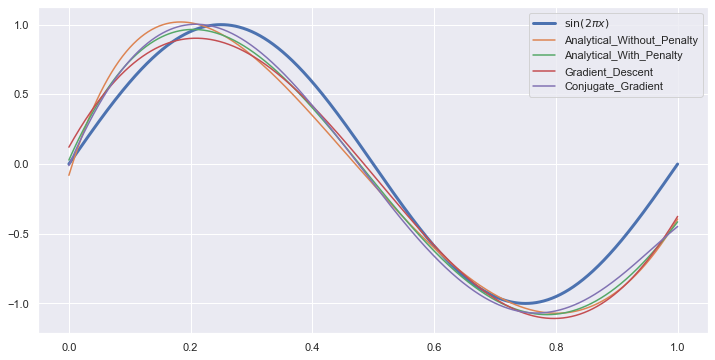

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(X_TEST, np.sin(2 * np.pi * X_TEST), linewidth=3)
for column in W_SOLUTION.columns:
    sns.lineplot(x=X_TEST, y=[W_SOLUTION[column] @ get_x_series(x=x, order=ORDER) for x in X_TEST])
plt.legend(["$\sin (2 \pi x)$"] + list(W_SOLUTION.columns))